In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.utils import resample
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, classification_report

%matplotlib inline
from sklearn import metrics


# Reading Dataset

In [3]:
df=pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")

In [4]:
df.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
df.shape

(8693, 14)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


# Data Inspecting and Cleaning 

In [7]:
df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [8]:
cols = ['Age','RoomService', 'FoodCourt','ShoppingMall','Spa','VRDeck']
df[cols]=df[cols].fillna(df.mode().iloc[0])

In [9]:
df.dropna(inplace=True)

In [10]:
df.isnull().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
dtype: int64

In [11]:
df.shape

(7559, 14)

## split mixed value into column

In [12]:
df[["Cabin_deck","Cabin_no.","Cabin_side"]]=df["Cabin"].str.split("/",expand=True)
df.drop(columns=["Cabin"],inplace=True)

df[["firstname","last_name"]]=df["Name"].str.split(" ",expand=True)
df.drop(columns=["Name"],inplace=True)

df[["Passenger_group","Passennger_no._in_group"]]=df["PassengerId"].str.split("_",expand=True)

## Outliers

In [13]:
num_features=df.describe().columns.tolist()
df_num=df[num_features]
df_num=df_num.drop(["Age"],axis=1)
df_num

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0.0,0.0,0.0,0.0,0.0
1,109.0,9.0,25.0,549.0,44.0
2,43.0,3576.0,0.0,6715.0,49.0
3,0.0,1283.0,371.0,3329.0,193.0
4,303.0,70.0,151.0,565.0,2.0
...,...,...,...,...,...
8688,0.0,6819.0,0.0,1643.0,74.0
8689,0.0,0.0,0.0,0.0,0.0
8690,0.0,0.0,1872.0,1.0,0.0
8691,0.0,1049.0,0.0,353.0,3235.0


In [14]:
df_num.describe()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,7559.000000,7559.000000,7559.000000,7559.000000,7559.000000
mean,216.605106,455.189972,172.829607,302.181109,298.372536
std,632.390329,1627.898926,562.125006,1118.241466,1117.819667
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,41.500000,63.000000,23.000000,54.000000,41.000000
max,9920.000000,29813.000000,12253.000000,22408.000000,20336.000000


In [15]:
df_num.median()

RoomService     0.0
FoodCourt       0.0
ShoppingMall    0.0
Spa             0.0
VRDeck          0.0
dtype: float64

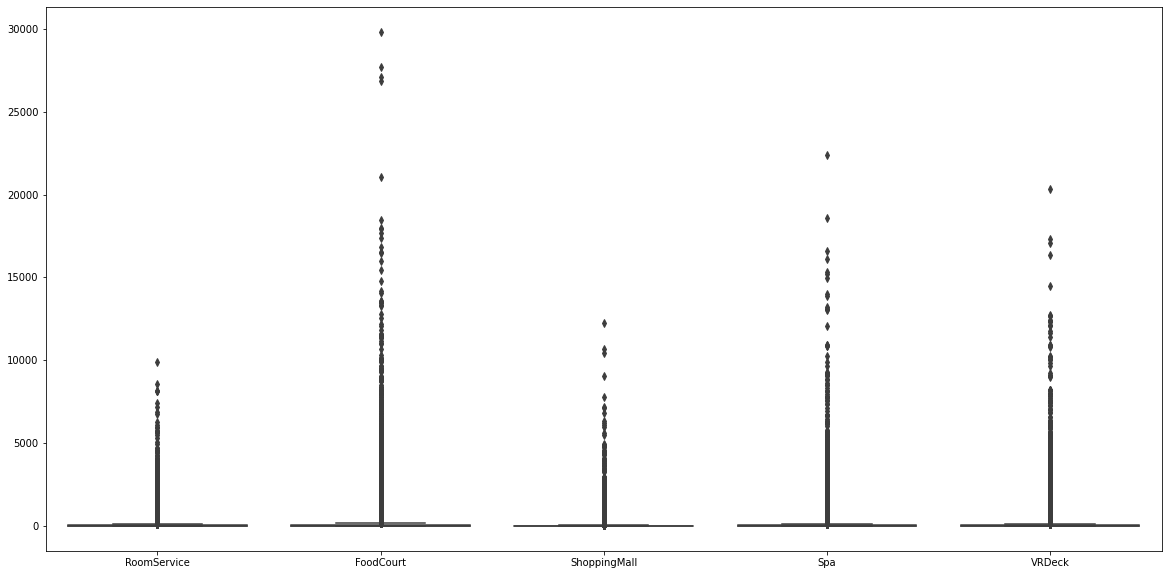

In [16]:
plt.figure(figsize=(20,10), facecolor='w')
sns.boxplot(data=df_num)
plt.show()

In [17]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7559 entries, 0 to 8692
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RoomService   7559 non-null   float64
 1   FoodCourt     7559 non-null   float64
 2   ShoppingMall  7559 non-null   float64
 3   Spa           7559 non-null   float64
 4   VRDeck        7559 non-null   float64
dtypes: float64(5)
memory usage: 354.3 KB


# Feature Selection

**Encode categorical featuers**